**Assignment 2** for the course of *Selected Topics in Music and Acoustic Engineering* : 

***Machine Learning for Audio and Acoustic Engineering*** 

helded by Professor *Maximo Cobos*.

---

STUDENTS GROUP:

+ **Fotios Koutsoukos**, ID: 941257

+ **Antonio Giganti**, ID: 925671

Link to the **[Google Colab](https://colab.research.google.com/drive/1vhkfcBtnov4ILf5qe7va1uHBx_urROnc?usp=sharing)** file.


If the textlink is not clickable, copy & paste the following link in your browser:
https://colab.research.google.com/drive/1vhkfcBtnov4ILf5qe7va1uHBx_urROnc?usp=sharing

---

# **Lab 2: Introduction to ML Methods in Audio**


In this lab we will explore some well-known Machine Learning methods making use of the Scikit-Learn library. We'll go through matrix factorization methods and some popular supervised and unsupervised learning techniques.


### **Exercise 1**: Importing a dataset from github

(*You don't need to do anything in this exercise but to execute the cells*)

Execute the following lines for importing the ESC-50 dataset:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import IPython.display as ipd
from pathlib import Path
import sklearn
plt.style.use('seaborn')

In [2]:
%%capture
!apt-get install subversion

In [3]:
%%capture
!svn checkout https://github.com/karolpiczak/ESC-50/trunk/audio

The Github repository specifies the following naming convention:

2000 audio recordings in WAV format (5 seconds, 44.1 kHz, mono) with the following naming convention:

{FOLD}-{CLIP_ID}-{TAKE}-{TARGET}.wav

{FOLD} - index of the cross-validation fold,

{CLIP_ID} - ID of the original Freesound clip,

{TAKE} - letter disambiguating between different fragments from the same Freesound clip,

{TARGET} - class in numeric format [0, 49].

In [4]:
%%capture
# Get a list of all audio files and get the class label for each file
audiofiles = [str(file) for file in Path().glob('audio/*.wav')]
labels = []
for i,file in enumerate(audiofiles):
  fileid = file.split('.wav')[-2]
  target = fileid.split('-')[-1]
  labels.append(int(target))
  
print(audiofiles)
print(labels) 

### **Exercise 2**: Represent the first 5 examples of the first 2 classes


Create 2 lists containing the paths for the 2 first classes (0 and 1). Name them 'class_0' and 'class_1'.

In [5]:
audiofiles = np.array(audiofiles)
labels = np.array(labels)

class_0 = audiofiles[labels==0]
class_1 = audiofiles[labels==1]

print(class_0.shape)
print(class_1.shape)

(40,)
(40,)


Read the audio files with librosa and store them in a list called 'signals_0' and 'signals_1':

In [6]:
signal_0 = list(librosa.load(a)[0] for a in class_0)
signal_1 = list(librosa.load(a)[0] for a in class_1)

Display the 5 first examples of the first 2 classes in a subplot of 2 rows and 5 columns:

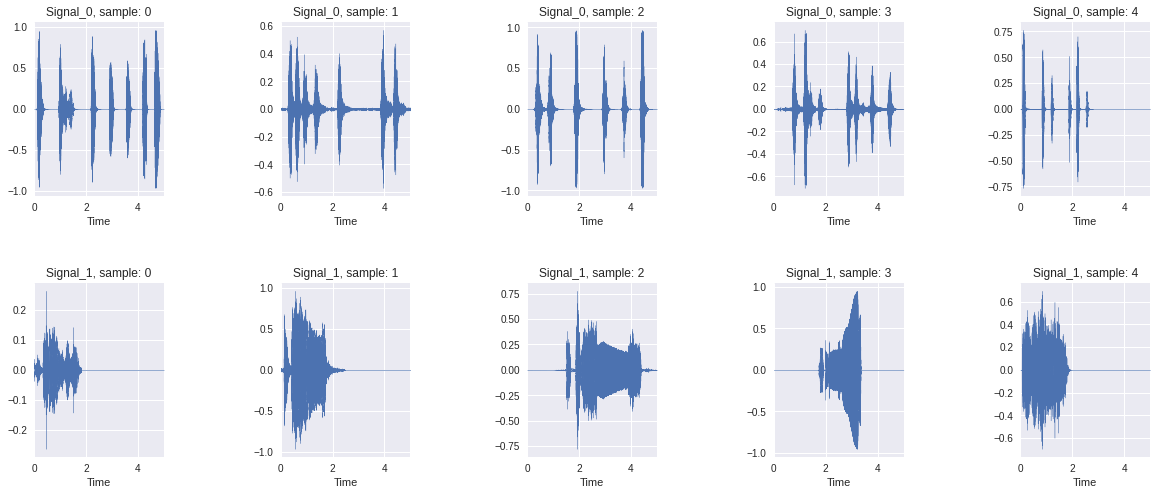

In [7]:
plt.figure(figsize=(20,8))
for i, x in enumerate(signal_0[0:5] + signal_1[0:5]):
  plt.subplot(2,5,i+1)
  librosa.display.waveplot(x)
  plt.subplots_adjust(hspace=0.5)
  plt.subplots_adjust(wspace=0.9)
  if i < 5:
    plt.title('Signal_0, sample: {}'.format(i))
  else:
    plt.title('Signal_1, sample: {}'.format(i%5))

### **Exercise 3**: NMF Decomposition


Listen to the first signal of class 0:

In [8]:
sr = 22050
ipd.Audio(signal_0[0], rate=sr)

Listen to the first signal of class 1:

In [9]:
ipd.Audio(signal_1[0], rate=sr)

Mix both signals together in a new array called 'audiomix':


In [10]:
#normalization
audiomix = signal_0[0]/signal_0[0].max() + signal_1[0]/signal_1[0].max()
audiomix = 0.5*audiomix/audiomix.max()

ipd.Audio(audiomix, rate=sr)

Decompose the 'audiomix' with 2 components using NMF:

In [11]:
S = librosa.stft(audiomix)
X, X_phase = librosa.magphase(S)

n_components = 2
W, H = librosa.decompose.decompose(X, n_components=n_components)

print(W.shape, H.shape)

(1025, 2) (2, 216)


Compare the original and approximated spectrum:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


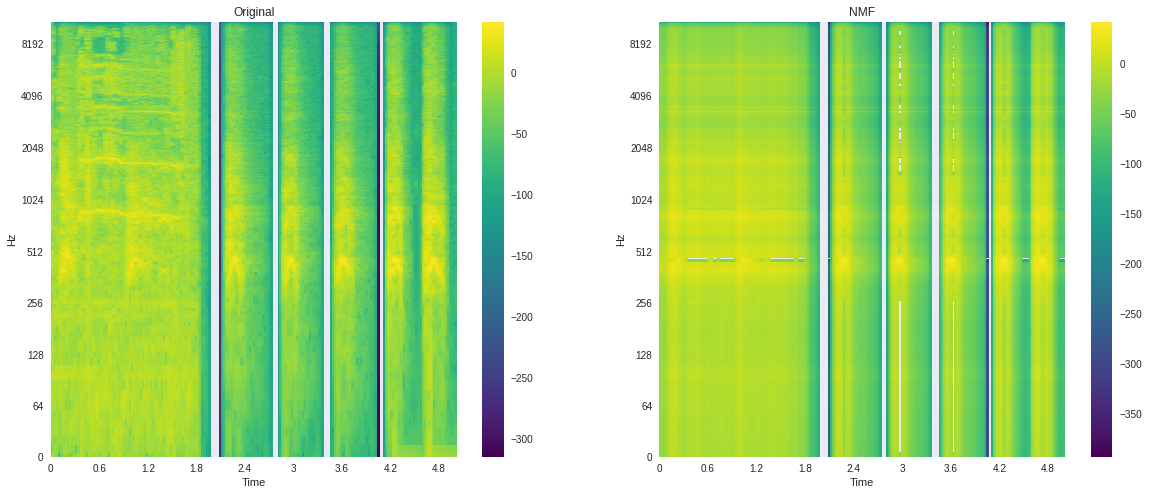

In [12]:
plt.figure(figsize=(20,8))

#original
plt.subplot(1,2,1)
librosa.display.specshow(20*np.log10(X), sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.title('Original')
plt.colorbar()

#after NMF 
plt.subplot(1,2,2)
librosa.display.specshow(20*np.log10(np.dot(W,H)), sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.title('NMF')
plt.colorbar();

Represent the learned spectral patterns:


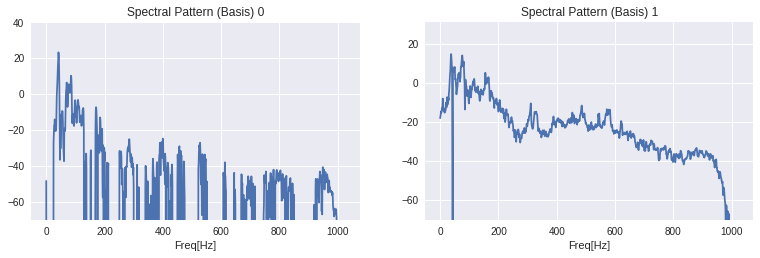

In [13]:
plt.figure(figsize=(20,8))
for i in range(n_components):
  plt.subplot(2,3,i+1)
  plt.plot(20*np.log10(W[:,i]+np.finfo(float).eps)) 
  plt.xlabel('Freq[Hz]')
  plt.title('Spectral Pattern (Basis) {}'.format(i))

  #plot adjustements
  plt.ylim(bottom=-70);

#+np.finfo(float).eps in order to add the smallest float avoiding division for zero


Represent the learned temporal activations:

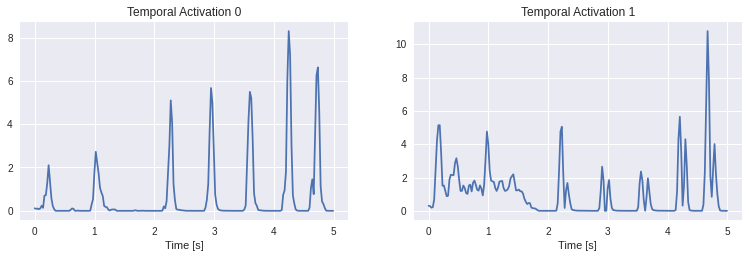

In [14]:
t_frames = librosa.frames_to_time(np.arange(H.shape[1]))

plt.figure(figsize=(20,8))
for i in range(n_components):
  plt.subplot(2,3,i+1)
  plt.plot(t_frames, H[i,:]) 
  plt.xlabel('Time [s]')
  plt.title('Temporal Activation {}'.format(i));

Reconstruct the temporal signal of each component (use the phase information of the original mix signal)

In [15]:
reconstructed_signals = []

for i in range(n_components):
  #reconstructed magnitude
  new_component = np.dot(np.expand_dims(W[:,i], axis=1), np.expand_dims(H[i,:], axis=0))
  #add phase
  new_component = new_component*np.exp(1j*X_phase)
  #come back to the time domain
  reconstructed_signals.append(librosa.core.istft(new_component))

Listen to the first component:

In [16]:
t_rec = (1.0/sr) * np.arange(reconstructed_signals[0].shape[0]) #time axis

ipd.Audio(reconstructed_signals[0], rate=sr)

Listen to the second component:

In [17]:
ipd.Audio(reconstructed_signals[1], rate=sr)

### **Exercise 4**: Harmonic-Percussive Decomposition

Now, apply librosa's harmonic-percussive source separation to extract again two components and discuss the perceived differences.

In [18]:
Hmm, Prs = librosa.decompose.hpss(X)

#these lines allow us to execute multiple instances of ipd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

h = librosa.istft(Hmm)
ipd.Audio(h, rate=sr)

p = librosa.istft(Prs)
ipd.Audio(p, rate=sr)

*The spectrogram on the left represent the harmonic contribution, as we can recognize from the horizontal harmonic lines.
On the other hand, the spectrogram on the right represent the temporal contribution. In fact, the temporal lines are spreaded vertically in the frequency axis, showing a percussive transient.* 

Represent the spectrograms of the two separated components.

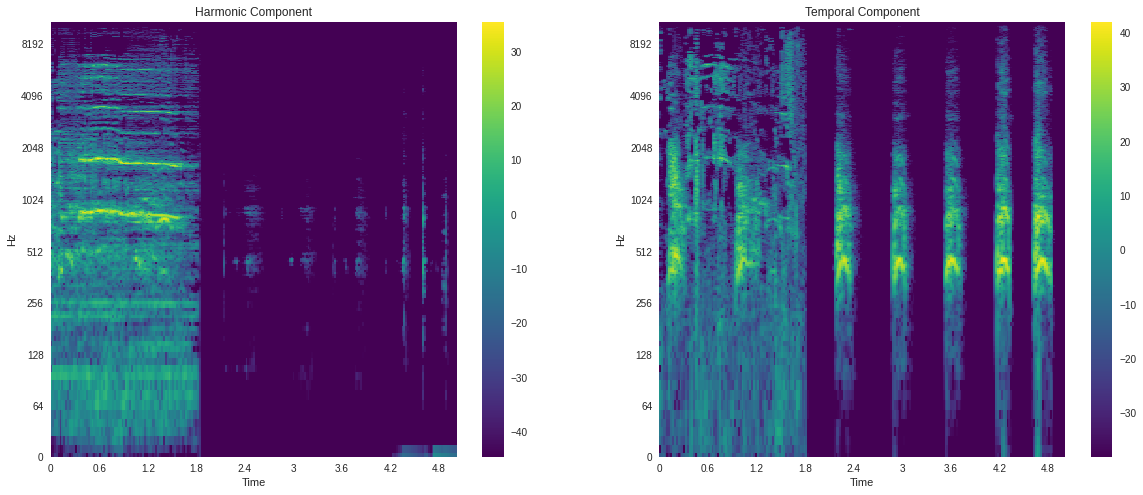

In [19]:
Hmag = librosa.amplitude_to_db(Hmm)
Pmag = librosa.amplitude_to_db(Prs)

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
librosa.display.specshow(Hmag, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.title('Harmonic Component')
plt.colorbar();

plt.subplot(1,2,2)
librosa.display.specshow(Pmag, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.title('Temporal Component')
plt.colorbar();

Listen to the first component.

In [20]:
ipd.Audio(h, rate=sr)

Listen to the second component.

In [21]:
ipd.Audio(p, rate=sr)

### **Exercise 5**: Feature Extraction

Compute the mean ZCR and standard deviation of the spectral flatness for the examples in signals_0 (dogs) and signals_1 (rooster). Define a function to extract those features (call it 'extract_features') and store the extracted features into two arrays: 'dog_features' and 'rooster_features'

In [22]:
# Function definition
def extract_features(signal):
  return [
          np.mean(librosa.feature.zero_crossing_rate(signal)[0,:]), 
          np.std(librosa.feature.spectral_flatness(signal)[0,:]),
  ]

In [23]:
# Feature Extraction
dog_features = np.array([extract_features(x) for x in signal_0])
rooster_features = np.array([extract_features(x) for x in signal_1])

print(dog_features.shape) #40 samples and 2 feature each
print(rooster_features.shape)

(40, 2)
(40, 2)


Represent the histograms for each feature for the two classes:

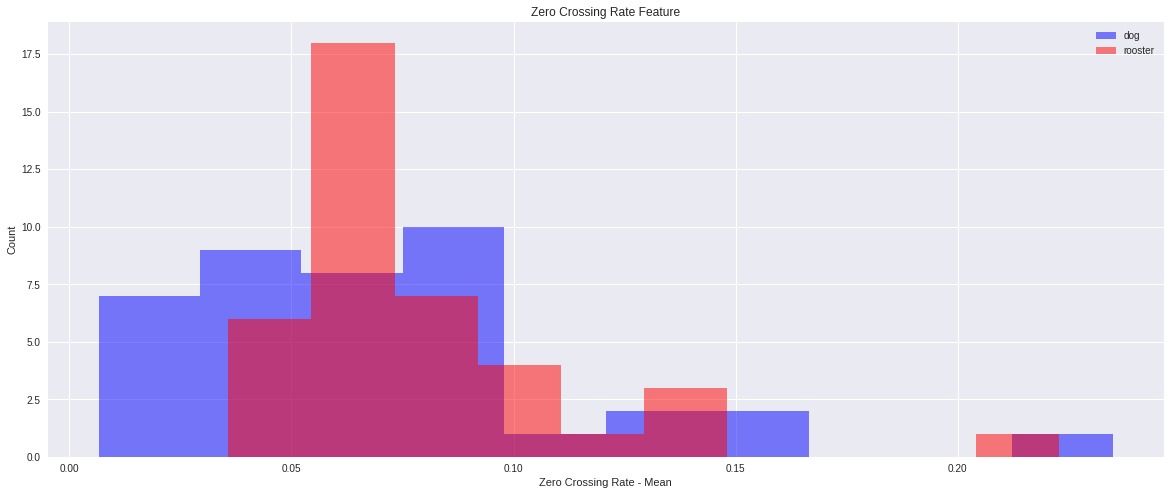

In [24]:
#First feature (ZCR)
plt.figure(figsize=(20,8))
plt.hist(dog_features[:,0], color='b', alpha=0.5, bins=10)
plt.hist(rooster_features[:,0], color='r', alpha=0.5, bins=10)
plt.title('Zero Crossing Rate Feature')
plt.legend(('dog','rooster'))
plt.xlabel('Zero Crossing Rate - Mean')
plt.ylabel('Count');

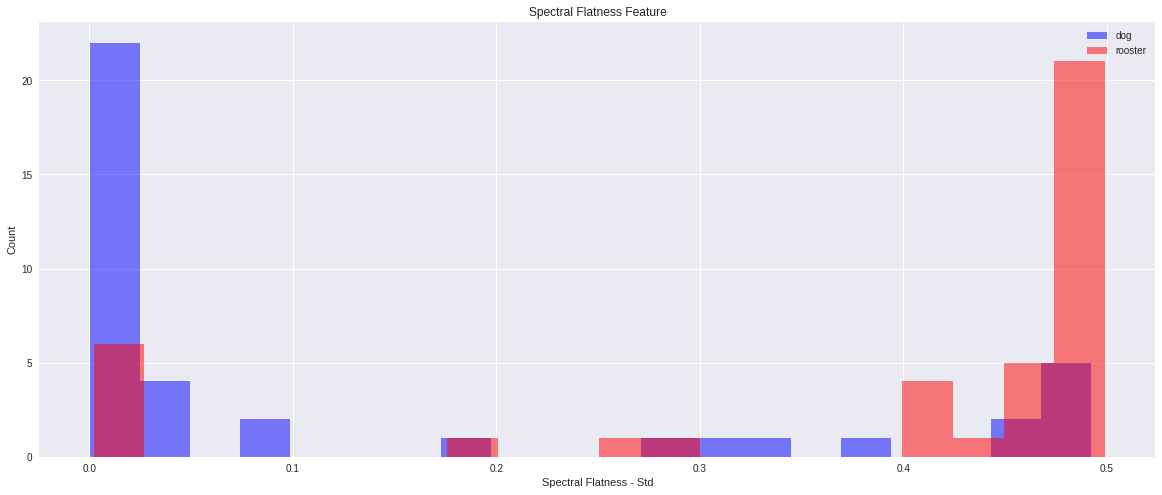

In [25]:
# Second feature (SF)
plt.figure(figsize=(20,8))
plt.hist(dog_features[:,1], color='b', alpha=0.5, bins=20)
plt.hist(rooster_features[:,1], color='r', alpha=0.5, bins=20)
plt.title('Spectral Flatness Feature')
plt.legend(('dog','rooster'))
plt.xlabel('Spectral Flatness - Std')
plt.ylabel('Count');

Discuss which of the two features seems to be better for classification.

*As we can see from the last histogram, the Standard Deviation of the Spectral Flatness is more robust and have a better discriminative power compared to the Mean of the Zero Crossing Rate, where there is grater overlapping area between the two classes.*

Represent a scatter plot of the two features for each class:

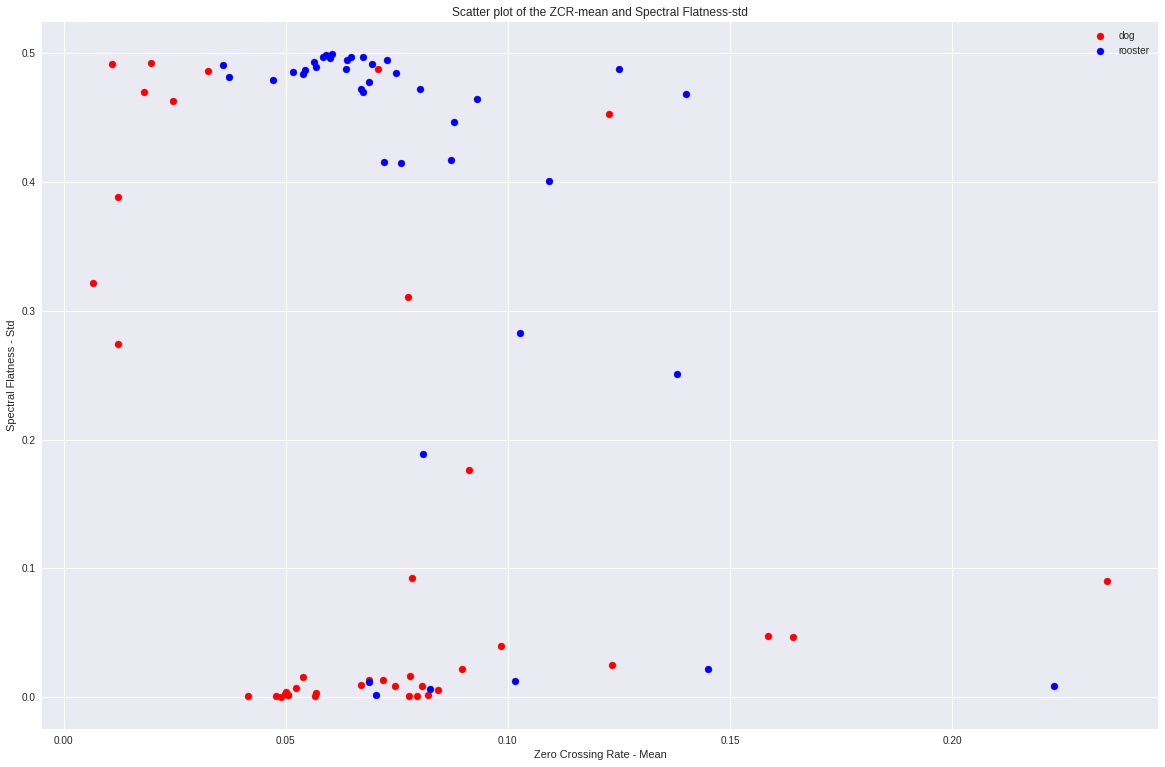

In [26]:
feature_table = np.vstack((dog_features, rooster_features)) 
labels_gt = np.hstack([np.ones((len(signal_0),)), np.zeros((len(signal_1),))]) 

#Features Scatter Plot 
plt.figure(figsize=(20,13))
plt.scatter(feature_table[labels_gt==1,0], feature_table[labels_gt==1,1], c='r')
plt.scatter(feature_table[labels_gt==0,0], feature_table[labels_gt==0,1], c='b')
plt.title('Scatter plot of the ZCR-mean and Spectral Flatness-std')
plt.legend(('dog','rooster'))
plt.xlabel('Zero Crossing Rate - Mean')
plt.ylabel('Spectral Flatness - Std');

### **Exercise 6**: Principal Component Analysis

Redefine the feature extractor to extract 3 features, adding to the previous ones the mean value of the spectral centroid.

In [27]:
# Function definition
def extract_features(signal):
  return [
          np.mean(librosa.feature.zero_crossing_rate(signal)[0,:]), 
          np.std(librosa.feature.spectral_flatness(signal)[0,:]),
          np.mean(librosa.feature.spectral_centroid(signal)[0,:]),
  ]

In [28]:
# Feature extraction
dog_features = np.array([extract_features(x) for x in signal_0])
rooster_features = np.array([extract_features(x) for x in signal_1])

print(dog_features.shape) #40 samples and 3 feature each
print(rooster_features.shape)

(40, 3)
(40, 3)


Create a matrix 'feature_table' stacking all the features a use sklearn 'scale' over such matrix. Create as well a label vector indicating the true label for each row of 'feature_table'

In [29]:
#Ground Truth already calculated in the last cell of exercise 5
#labels_gt = np.hstack([np.ones((len(signal_0),)), np.zeros((len(signal_1),))])

feature_table = np.vstack((dog_features, rooster_features)) 

print(feature_table.shape) 
print(len(labels_gt))

#create a scaler using sklearn
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1))

#apply the scaler over the feature_table matrix
training_features = scaler.fit_transform(feature_table)

(80, 3)
80


Represent each example in a 3D feature space scatterplot:

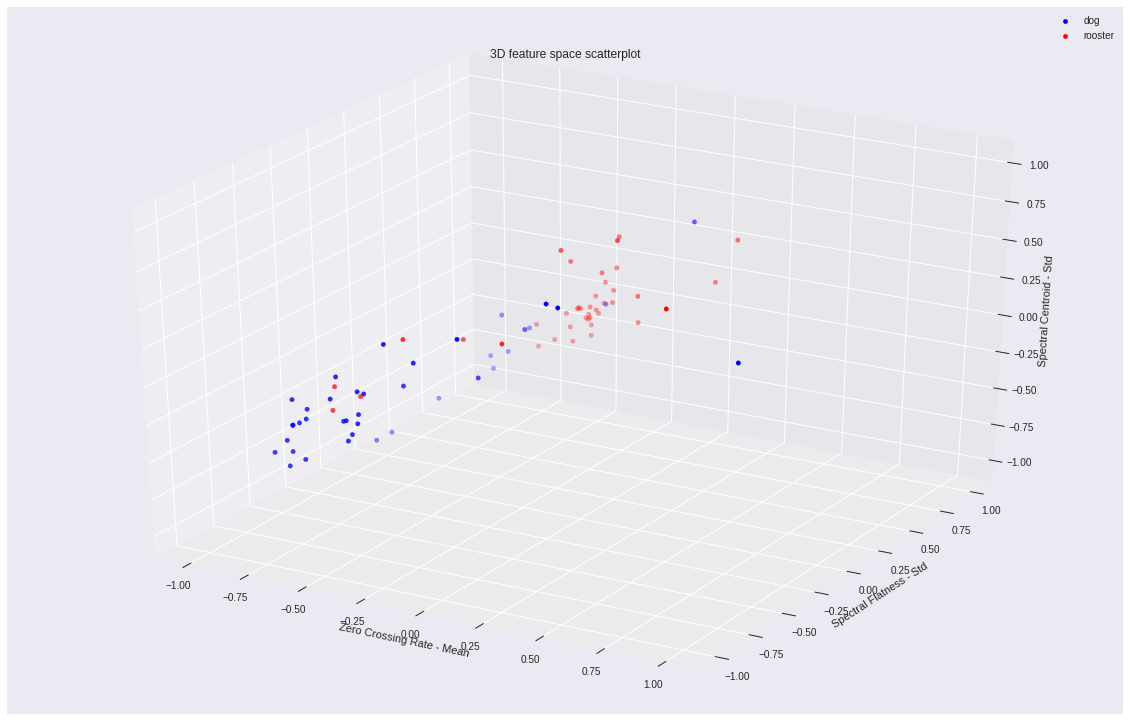

In [30]:
fig = plt.figure(figsize=(20,13))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(training_features[labels_gt==1,0], training_features[labels_gt==1,1], training_features[labels_gt==1,2], c='b')
ax.scatter(training_features[labels_gt==0,0], training_features[labels_gt==0,1], training_features[labels_gt==0,2], c='r'); 
ax.legend(('dog','rooster'))
ax.set_title('3D feature space scatterplot')
ax.set_xlabel('Zero Crossing Rate - Mean')
ax.set_ylabel('Spectral Flatness - Std')
ax.set_zlabel('Spectral Centroid - Std');

Apply PCA for reducing the dimensionality to two dimensions and plot the corresponding scatterplot:

(80, 2)
[[7.90000000e+01 3.12585838e-14]
 [3.12585838e-14 7.90000000e+01]]


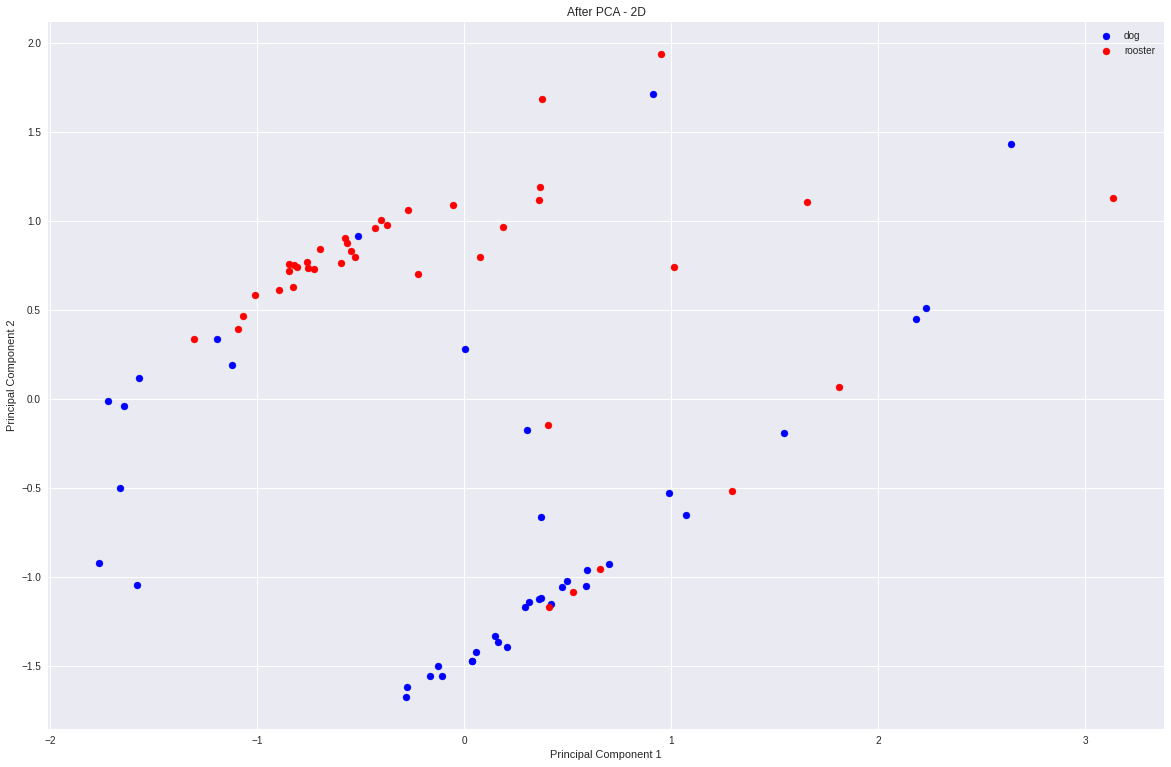

In [31]:
#Data Standardization, Std=1, Mean=0
X = sklearn.preprocessing.scale(training_features, axis=0)

#Create dimensionality reduction object
n_comp=2
model = sklearn.decomposition.PCA(n_components=n_comp, whiten=True) 

#Learn the tranformation matrix from our data
model.fit(X)

#Apply the tranformation
Y = model.transform(X)
print(Y.shape) 

print(np.dot(Y.T,Y)) #diagonal matrix

#Plotting The Result
plt.figure(figsize=(20,13))
plt.scatter(Y[labels_gt==1,0], Y[labels_gt==1,1], c='b')
plt.scatter(Y[labels_gt==0,0], Y[labels_gt==0,1], c='r')
plt.title('After PCA - 2D')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(('dog', 'rooster'));
#from 3d --> 2d



### **Exercise 7**: Support Vector Machines

Fit a linear SVM classifier with parameter C=1 to the PCA transformed data. Use the following helper function to draw the classifier hyperplanes of interest:


In [32]:
def draw_classplane(ax,model,xrange):
  w = model.coef_[0]
  b = model.intercept_[0]
  a = -w[0] / w[1]
  xx = np.linspace(-3, 3)
  yy = a * xx - (b/ w[1])
  margin = 1 / np.sqrt(np.sum(w** 2))
  yy_down = yy - np.sqrt(1 + a ** 2) * margin
  yy_up = yy + np.sqrt(1 + a ** 2) * margin
  ax.plot(xx, yy, 'k-')
  ax.plot(xx, yy_down, 'k--')
  ax.plot(xx, yy_up, 'k--')

In [33]:
# Model fitting
penalty = 1
model = sklearn.svm.SVC(kernel='linear', C=penalty)
model.fit(Y, labels_gt)
# Model prediction
labels = model.predict(Y)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Represent two subplots to compare the ground truth data and the classification result. Plot the classification hyperplanes and margin.

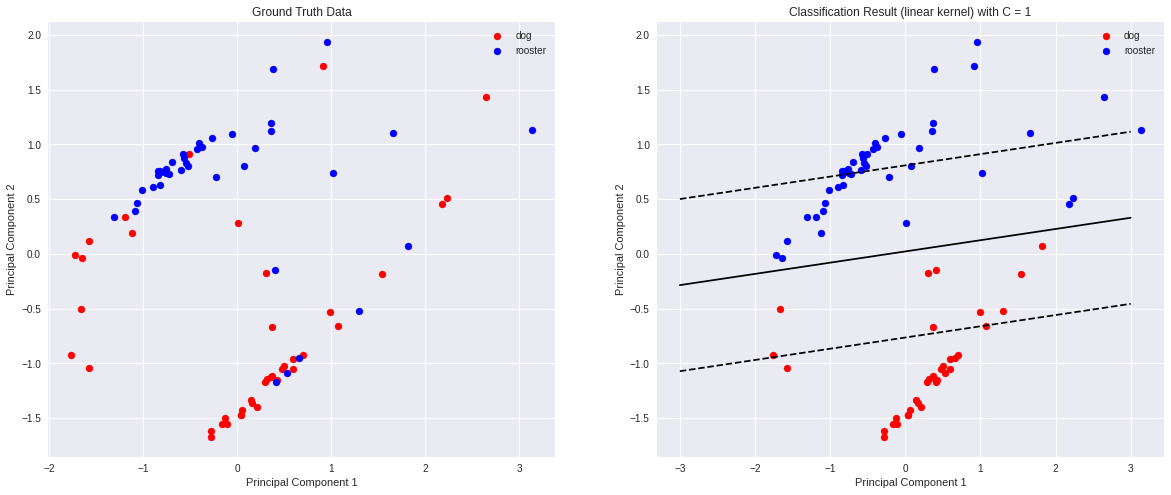

In [34]:
plt.figure(figsize=(20,8))

#Ground Truth Data
plt.subplot(1,2,1)
plt.scatter(Y[labels_gt==1,0], Y[labels_gt==1,1], c='r') 
plt.scatter(Y[labels_gt==0,0], Y[labels_gt==0,1], c='b')
plt.title('Ground Truth Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(('dog', 'rooster'))

#Classification Result
ax2 = plt.subplot(1,2,2)
plt.scatter(Y[labels==1,0], Y[labels==1,1], c='r')
plt.scatter(Y[labels==0,0], Y[labels==0,1], c='b')
plt.title('Classification Result (linear kernel) with C = {}'.format(penalty))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(('dog', 'rooster'))

#Draw Hyperplane and margins
draw_classplane(plt.gca(), model, (-1,1));

Compute the accuracy of the classification result using sklearn:

In [35]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(labels_gt, labels)
print('Accuracy: ', acc)

Accuracy:  0.7875


Now, apply a RBF kernel for non-linear classification:

In [36]:
model = sklearn.svm.SVC(kernel='rbf', C=penalty)
model.fit(Y, labels_gt)
labels = model.predict(Y)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Draw the resulting classification contour and compute the accuracy:

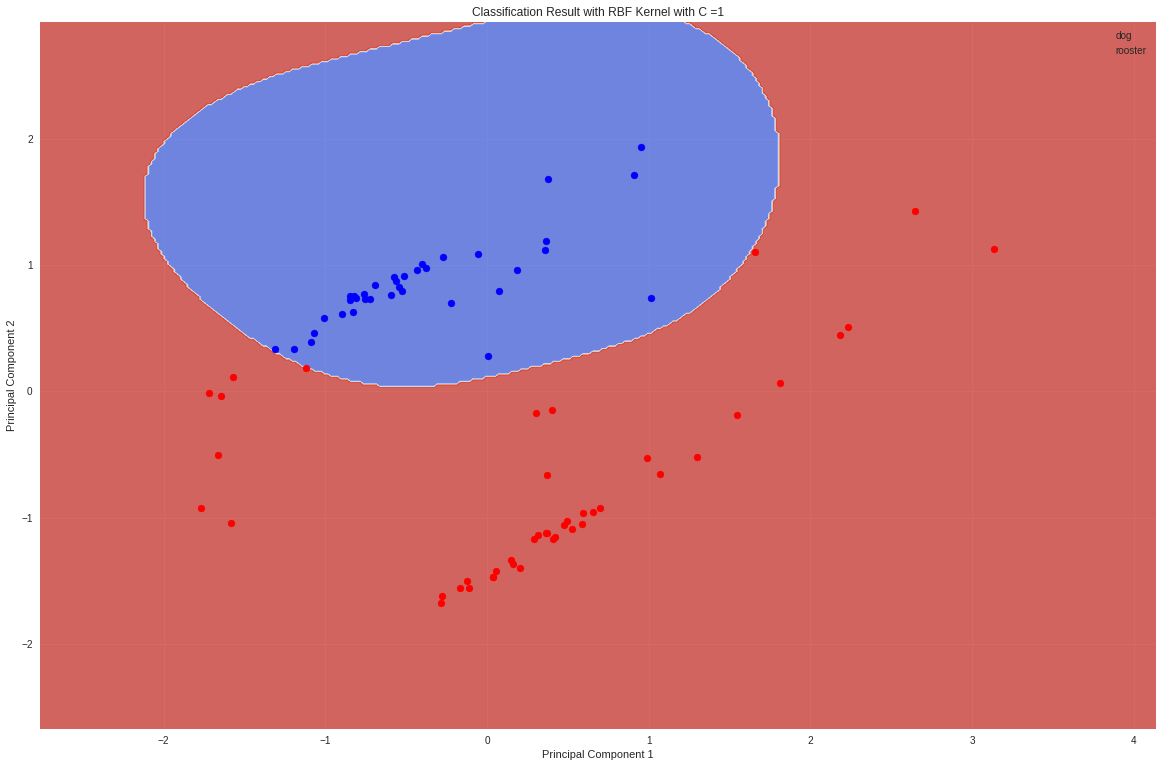

In [37]:
plt.figure(figsize=(20,13))

#for representation purposes
h = 0.02
x_min, x_max = Y[:,0].min() -1 , Y[:,0].max() +1
y_min, y_max = Y[:,1].min() -1 , Y[:,1].max() +1
xx, yy = np.meshgrid(np.arange(x_min,x_max,h), np.arange(y_min, y_max,h))

#display the boundary by predicting on every point on the grid
Z = model.predict(np.c_[ xx.ravel(), yy.ravel()])
# Put the result into color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap = plt.cm.coolwarm, alpha = 0.8)

plt.xlim(xx.min(), xx.max());
plt.ylim(yy.min(), yy.max());

plt.scatter(Y[labels==1,0],Y[labels==1,1],c='r')
plt.scatter(Y[labels==0,0],Y[labels==0,1],c='b')
plt.title('Classification Result with RBF Kernel with C ={}'.format(penalty))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(('dog', 'rooster'));

In [38]:
acc = accuracy_score(labels_gt, labels)
print('Accuracy: ', acc)

Accuracy:  0.85


Experiment with different parameters of C. Try different values also for the "gamma" parameter of the RBF kernel.

Find a combination of parameters representing an overfitting and underfitting.


*The `gamma` parameter defines the bandwidth of the Gaussian Kernel.
Gamma is inverse proportional to the variance.
Here we test different values of gamma keeping C value constant.*

**Case 1 - Small value of `gamma`**

*This is the case of underfitting because the bandwidth of the Gaussian Kernel is large. 
As we can see from the plot below, the classifier becomes almost linear.
The model generalizes too much and cannot capture the complexity of the data structure.* 


In [39]:
# UNDERFITTING
gamma = 0.01

model = sklearn.svm.SVC(kernel='rbf', C=penalty, gamma=gamma)
model.fit(Y, labels_gt)
labels = model.predict(Y)


SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

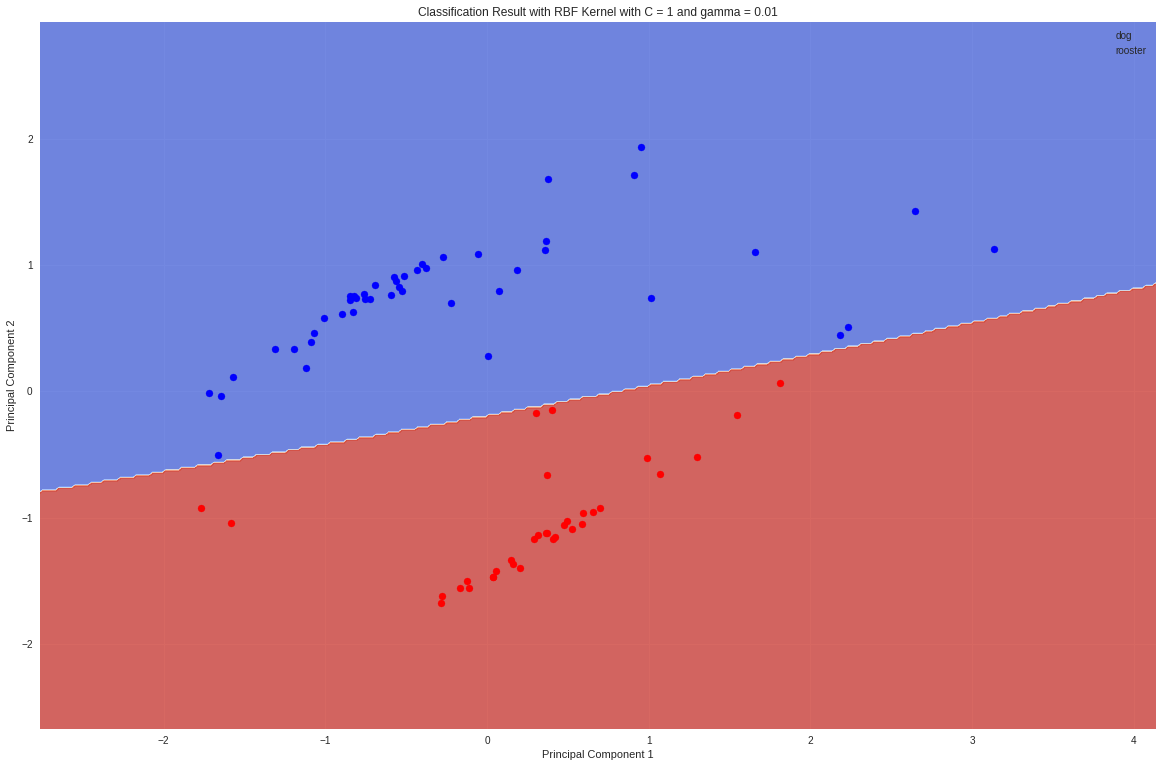

In [40]:
#Plotting the result

plt.figure(figsize=(20,13))

#for representation purposes
h = 0.02
x_min, x_max = Y[:,0].min() -1 , Y[:,0].max() +1
y_min, y_max = Y[:,1].min() -1 , Y[:,1].max() +1
xx, yy = np.meshgrid(np.arange(x_min,x_max,h), np.arange(y_min, y_max,h))

#display the boundary by predicting on every point on the grid
Z = model.predict(np.c_[ xx.ravel(), yy.ravel()])
# Put the result into color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap = plt.cm.coolwarm, alpha = 0.8)

plt.xlim(xx.min(), xx.max());
plt.ylim(yy.min(), yy.max());

plt.scatter(Y[labels==1,0],Y[labels==1,1],c='r')
plt.scatter(Y[labels==0,0],Y[labels==0,1],c='b')
plt.title('Classification Result with RBF Kernel with C = {} and gamma = {}'.format(penalty, gamma))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(('dog', 'rooster'));

In [41]:
acc = accuracy_score(labels_gt, labels)
print('Accuracy: ', acc)

Accuracy:  0.775


**Case 2 - Big value of `gamma`**

*In this case the bandwidth of the Gaussian Kernel is very small and we can see "islands" being created in the output space.
This means that the classifier learns the exact position of the data during training and not the real trend behind them.
Since we evaluate the prediction over the same dataset used to train the model, the overfitted model has a very high accuracy. 
But, in the case of prediction using an unknown test set the accuracy drops significantly.*

In [42]:
# OVERFITTING
gamma = 100

model = sklearn.svm.SVC(kernel='rbf', C=penalty, gamma=gamma)
model.fit(Y, labels_gt)
labels = model.predict(Y)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

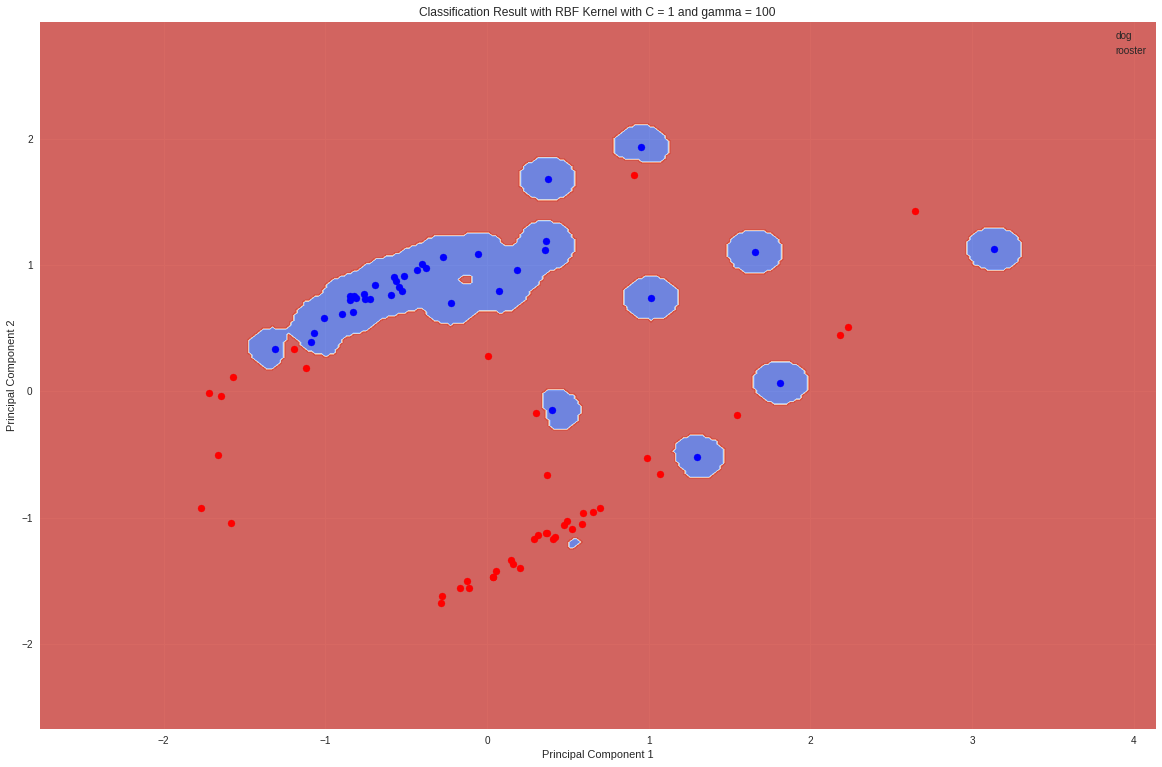

In [43]:
#Plotting the result

plt.figure(figsize=(20,13))

#for representation purposes
h = 0.02
x_min, x_max = Y[:,0].min() -1 , Y[:,0].max() +1
y_min, y_max = Y[:,1].min() -1 , Y[:,1].max() +1
xx, yy = np.meshgrid(np.arange(x_min,x_max,h), np.arange(y_min, y_max,h))

#display the boundary by predicting on every point on the grid
Z = model.predict(np.c_[ xx.ravel(), yy.ravel()])
# Put the result into color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap = plt.cm.coolwarm, alpha = 0.8)

plt.xlim(xx.min(), xx.max());
plt.ylim(yy.min(), yy.max());

plt.scatter(Y[labels==1,0],Y[labels==1,1],c='r')
plt.scatter(Y[labels==0,0],Y[labels==0,1],c='b')
plt.title('Classification Result with RBF Kernel with C = {} and gamma = {}'.format(penalty, gamma))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(('dog', 'rooster'));

In [44]:
acc = accuracy_score(labels_gt, labels)
print('Accuracy: ', acc)

Accuracy:  0.95


### **Exercise 8**: k-Means Clustering

Cluster the PCA projected data into two groups using k-Means.

In [45]:
input = Y
n_cluster = 2
model = sklearn.cluster.KMeans(n_clusters=n_cluster)
labels = model.fit_predict(input)

Represent the scatterplots of the original data and the two resultant clusters. Plot the final k-Means centroids as well.

In [46]:
#in order to correct the unwanted swapping color (and accuracy too)
acc = accuracy_score(labels_gt, labels)
if 1-acc > acc:
  acc = 1-acc
  labels = 1 - labels

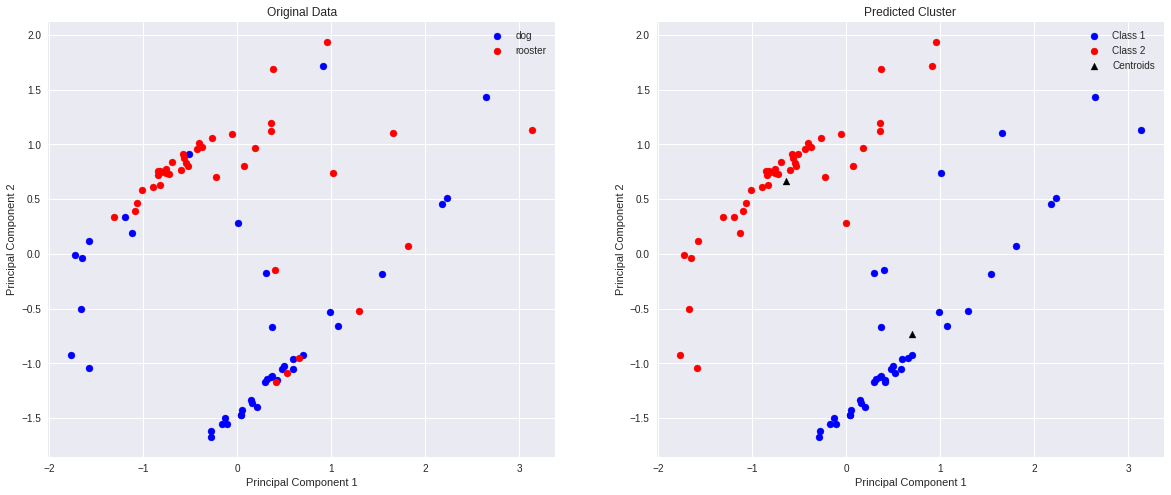

In [47]:
plt.figure(figsize=(20,8))

#Ground Truth Data
plt.subplot(1,2,1)
plt.scatter(input[labels_gt==1,0], input[labels_gt==1,1], c='b')
plt.scatter(input[labels_gt==0,0], input[labels_gt==0,1], c='r')
plt.title('Original Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(('dog', 'rooster'))

#Classification Result
plt.subplot(1,2,2)
plt.scatter(input[labels==1,0], input[labels==1,1], c='b')
plt.scatter(input[labels==0,0], input[labels==0,1], c='r')
plt.title('Predicted Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.scatter(model.cluster_centers_[:,0] ,model.cluster_centers_[:,1], color='black', marker='^')
plt.legend(('Class 1', 'Class 2', 'Centroids'));

### **Exercise 9**: k-NN

Fit a k-NN classifier to the same data and experiment with different k parameters. Discuss the results.

*The `k` parameter defines the number of neighbors within the defined distance (similarity measure) to perform majority voting.
When `k` is very small, the classifier tends to overfit since we use locality as our primary criterion for classification.
When `k` in too large, our classifier underfits and resambles the average classifier.*

**Case 1 - `k_param` = 1**

In [48]:
k_param = 1
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k_param)
model.fit(input,labels_gt)
labels = model.predict(input)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

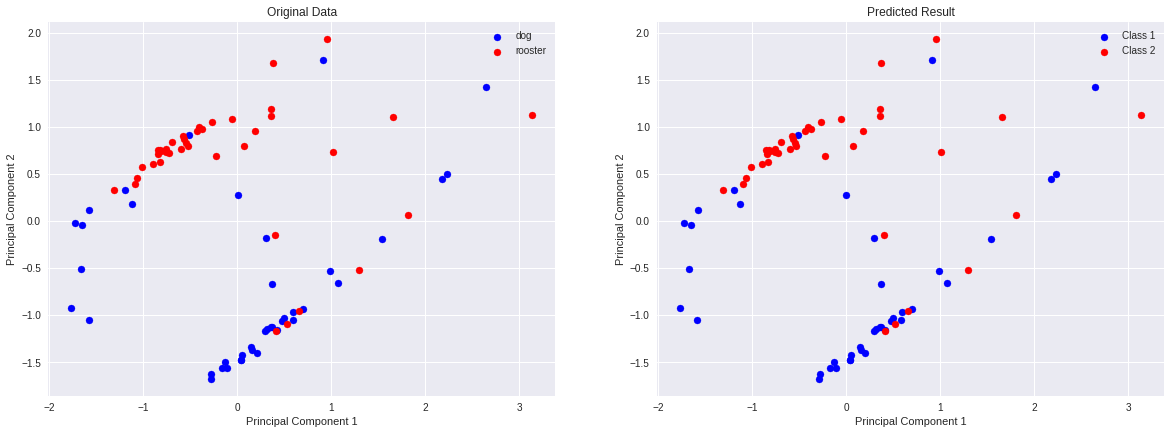

In [49]:
plt.figure(figsize=(20,8))

#Ground Truth Data
ax1 = plt.subplot(1,2,1)
plt.scatter(input[labels_gt==1,0], input[labels_gt==1,1], c='b')
plt.scatter(input[labels_gt==0,0], input[labels_gt==0,1], c='r')
plt.title('Original Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(('dog', 'rooster'))
ax1.set_aspect('equal')

#Classification Result
ax2 = plt.subplot(1,2,2)
plt.scatter(input[labels==1,0], input[labels==1,1], c='b')
plt.scatter(input[labels==0,0], input[labels==0,1], c='r')
plt.title('Predicted Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(('Class 1', 'Class 2'));
ax2.set_aspect('equal');

**Case 2 - `k_param` = 15**

In [50]:
k_param = 15
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k_param)
model.fit(input,labels_gt)
labels = model.predict(input)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

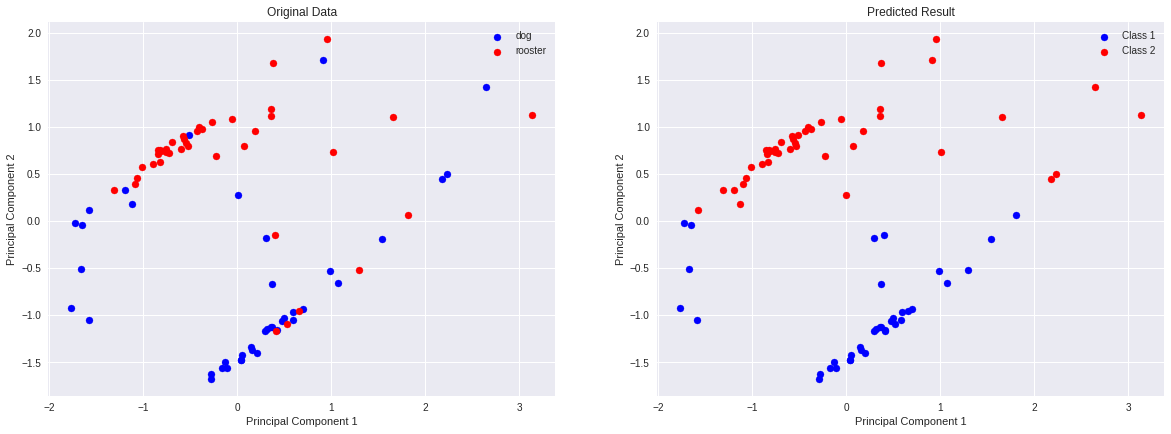

In [51]:
plt.figure(figsize=(20,8))

#Ground Truth Data
ax1 = plt.subplot(1,2,1)
plt.scatter(input[labels_gt==1,0], input[labels_gt==1,1], c='b')
plt.scatter(input[labels_gt==0,0], input[labels_gt==0,1], c='r')
plt.title('Original Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(('dog', 'rooster'))
ax1.set_aspect('equal')

#Classification Result
ax2 = plt.subplot(1,2,2)
plt.scatter(input[labels==1,0], input[labels==1,1], c='b')
plt.scatter(input[labels==0,0], input[labels==0,1], c='r')
plt.title('Predicted Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(('Class 1', 'Class 2'));
ax2.set_aspect('equal');

In [ ]:
#this cell is for printing purpose
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Student_Lab_2.ipynb')